# Imports

In [1]:
cd /home/tvangraft/tudelft/thesis/metaengineering

/home/tvangraft/tudelft/thesis/metaengineering


In [2]:
import os
import glob
import json
import ast
import re

from typing import Dict, List

from src.utils.parsers.cv_parser import fmt_cv_results
from src.utils.visualizers.prediction_figures import PredictionFigures
from src.utils.visualizers.test_figures import TestFigures
from src.utils.visualizers.cv_figures import CVFigures
from src.settings.strategy import Strategy

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [3]:
def get_metabolite_info():
    metabolite_data = pd.read_csv('./data/training/metabolites.txt', delimiter='\t')
    raw_metabolites = pd.read_csv('./data/training/metabolites_dataset.data_prep.tsv', delimiter='\t')

    return raw_metabolites.merge(
        metabolite_data, 
        left_on='official_name', right_on='met_name'
    )[['metabolite_id', 'official_name', 'kegg_id', 'pathway', 'method', 'Order']].drop_duplicates().set_index('metabolite_id')

def gather_results(paths: List[str]):
    metabolites_names = [path.rsplit('/', 1)[1].removesuffix('.csv').removeprefix('Strategy.METABOLITE_CENTRIC_') for path in paths]
    df = pd.concat([
        pd.read_csv(path).assign(metabolite_id=metabolite_name) 
        for path, metabolite_name in zip(paths, metabolites_names)
    ])
    return df

def combine_metabolite_info(df):
    metabolite_info = get_metabolite_info()
    df = df.merge(metabolite_info, left_on='metabolite_id', right_index=True)
    return df

In [4]:
metabolite_info = get_metabolite_info()

In [15]:
class ResultFetcher:
    def __init__(self, root_dir: str, metabolite_info: pd.DataFrame) -> None:
        self.root_dir = root_dir
        self.metabolite_info = metabolite_info
    
    def get_all(self, experiment_id: int):
        test_df_all = self.get_test_df_all(experiment_id)
        test_df_metabolite = self.get_test_df_metabolite(experiment_id)
        test_df_one_vs_all = self.get_test_df_one_vs_all(experiment_id)
        return test_df_all, test_df_metabolite, test_df_one_vs_all
    
    def get_test_df_all(self, experiment_id: int):
        df = self.get_frame(experiment_id, Strategy.ALL)
        df = df.assign(strategy='all').assign(experiment_id=experiment_id)
        return df
    
    def get_test_df_metabolite(self, experiment_id: int):
        df = self.get_frame(experiment_id, Strategy.METABOLITE_CENTRIC)
        df = df.assign(strategy='metabolite').assign(experiment_id=experiment_id)
        return df
    
    def get_test_df_one_vs_all(self, experiment_id: int):
        df = self.get_frame(experiment_id, Strategy.ONE_VS_ALL)
        df = df.assign(strategy='one_vs_all').assign(experiment_id=experiment_id)
        return df
        
    def get_frame(self, experiment_id: int, strategy: Strategy):
        path = f"{self.root_dir}/experiment_{experiment_id}/best_model_performance_{strategy}.csv"
        print(path)
        if self.file_exists(path):
            test_df_all = pd.read_csv(path, index_col=0)
            test_df_all = test_df_all.stack().to_frame().reset_index(1).set_axis(['metabolite_arch', 'r2'], axis=1)
            test_df_all[['metabolite_id', 'architecture']] = test_df_all['metabolite_arch'].str.split("_", expand=True)
            test_df_all = test_df_all.drop('metabolite_arch', axis=1).merge(metabolite_info, left_on='metabolite_id', right_index=True)
            return test_df_all
    
    def file_exists(self, path: str):
        return os.path.exists(path)

In [ ]:
result_fetcher = ResultFetcher(
    root_dir="/home/tvangraft/tudelft/thesis/metaengineering/data/results",
    metabolite_info=metabolite_info
)

In [16]:
test_df_all, test_df_metabolite, test_df_one_vs_all = result_fetcher.get_all(0)
test_df = pd.concat([test_df_all, test_df_metabolite, test_df_one_vs_all], axis=0)
test_df_arch_all = test_df[test_df['architecture'] == 'all']
test_figures = TestFigures(test_df_arch_all)

/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0/best_model_performance_Strategy.ALL.csv
/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0/best_model_performance_Strategy.METABOLITE_CENTRIC.csv
/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0/best_model_performance_Strategy.ONE_VS_ALL.csv


In [20]:
test_df_all = pd.concat([result_fetcher.get_test_df_all(i) for i in range(2)])
test_df_metabolite = pd.concat([result_fetcher.get_test_df_metabolite(i) for i in range(2)])
test_df_one_vs_all = pd.concat([result_fetcher.get_test_df_one_vs_all(i) for i in range(2)])

test_df = pd.concat([test_df_all, test_df_metabolite, test_df_one_vs_all], axis=0)
test_df_arch_all = test_df[test_df['architecture'] == 'all']
test_figures = TestFigures(test_df_arch_all)

/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0/best_model_performance_Strategy.ALL.csv
/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_1/best_model_performance_Strategy.ALL.csv
/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0/best_model_performance_Strategy.METABOLITE_CENTRIC.csv
/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_1/best_model_performance_Strategy.METABOLITE_CENTRIC.csv
/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0/best_model_performance_Strategy.ONE_VS_ALL.csv
/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_1/best_model_performance_Strategy.ONE_VS_ALL.csv


In [21]:
test_df_arch_all.sort_values('metabolite_id')

,r2,metabolite_id,architecture,official_name,kegg_id,pathway,method,Order,strategy,experiment_id
0,0.946054,3pg;2pg,all,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,all,0
0,0.033214,3pg;2pg,all,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,metabolite,1
0,0.321946,3pg;2pg,all,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,metabolite,0
0,0.895126,3pg;2pg,all,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,all,1
0,0.072642,3pg;2pg,all,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,one_vs_all,1
...,...,...,...,...,...,...,...,...,...,...
0,0.043974,r5p,all,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,metabolite,1
0,0.854081,r5p,all,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,all,1
0,0.881218,r5p,all,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,all,0
0,0.887741,r5p,all,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,one_vs_all,0


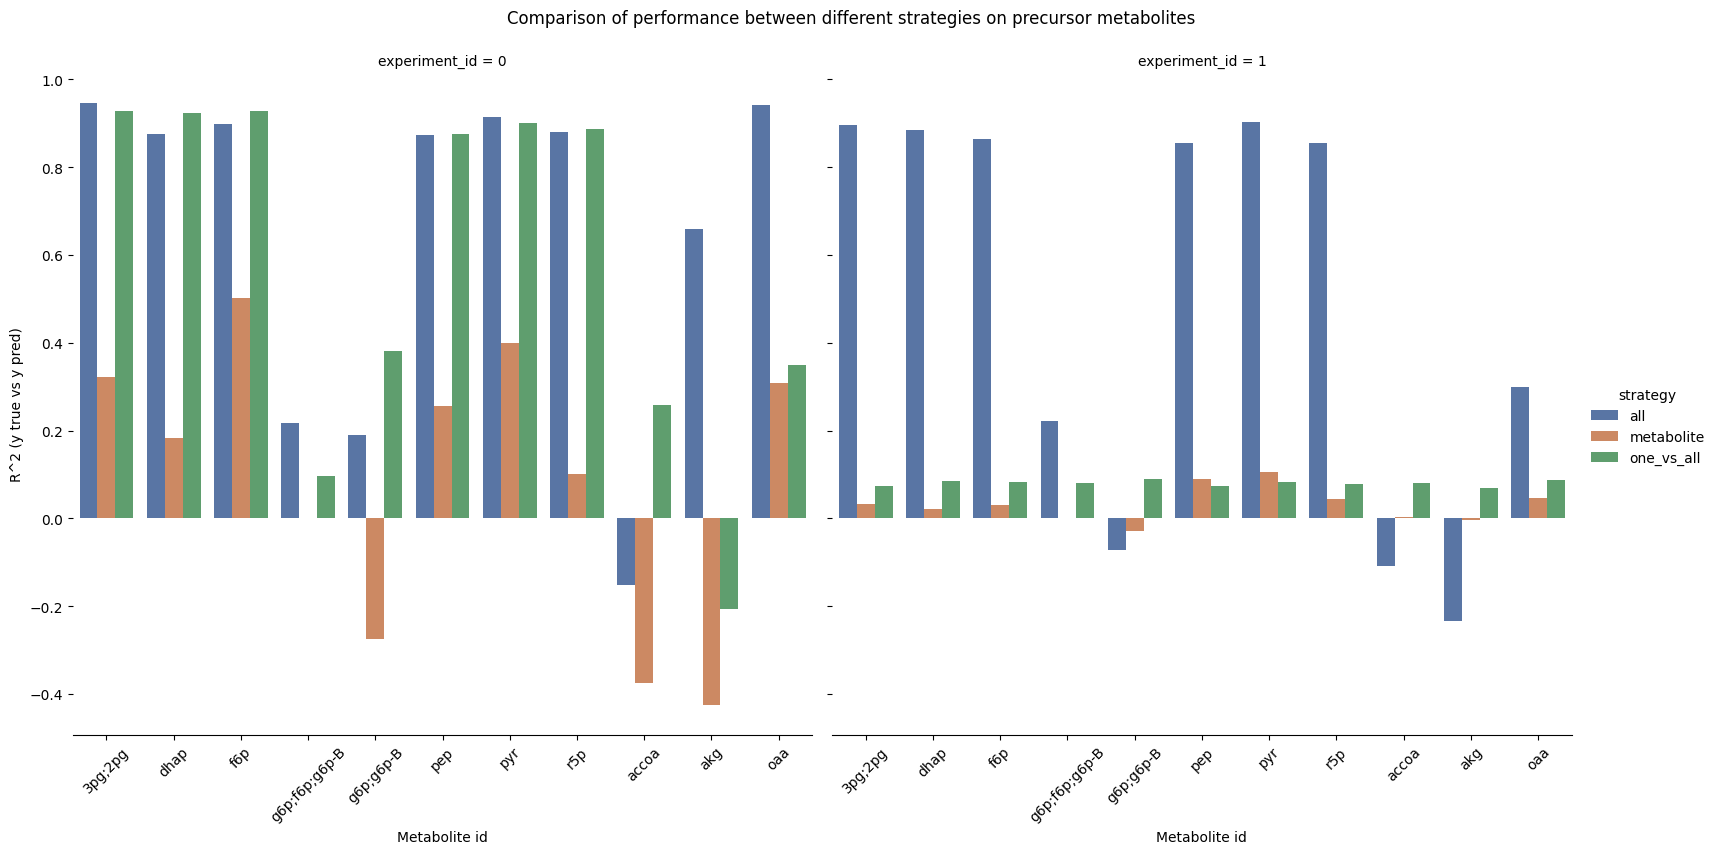

In [29]:
_df = test_df_arch_all.sort_values(['pathway', 'metabolite_id'])
g = sns.catplot(
    data=_df, 
    col='experiment_id',
    kind='bar',
    x='metabolite_id',
    y='r2',
    hue='strategy',
    palette='deep',
    height=8,
)
g.despine(left=True)
# g.set(yscale='symlog')

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Comparison of performance between different strategies on precursor metabolites')

g.set(
    # title='Comparison of performance between different strategies on precursor metabolites',
    xlabel='Metabolite id',
    ylabel="R^2 (y true vs y pred)"
)

plt.savefig('./images/performance/comparison_between_different_strategies_using_optimal_model.png', bbox_inches='tight')
plt.savefig('./images/performance/comparison_between_different_strategies_using_optimal_model.svg', bbox_inches='tight')

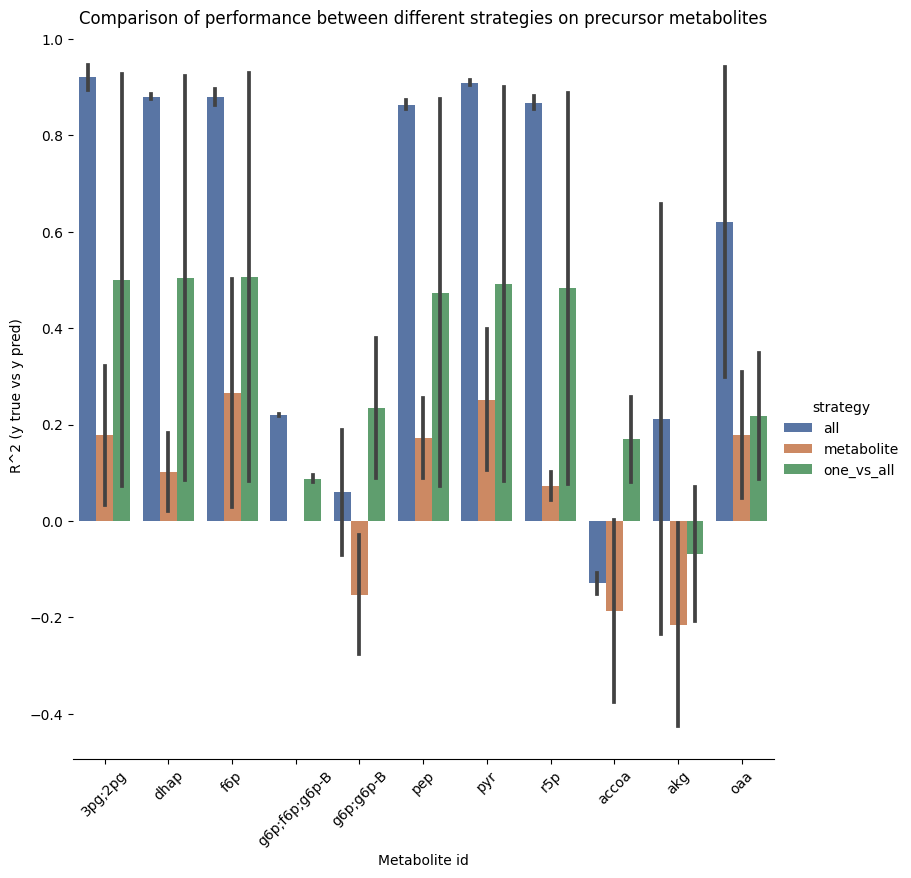

In [22]:
g = test_figures.r2_per_tier(plot_args=dict(height=8))
g.set(
    title='Comparison of performance between different strategies on precursor metabolites',
    xlabel='Metabolite id',
    ylabel="R^2 (y true vs y pred)"
)

# plt.tight_layout()
plt.savefig('./images/performance/comparison_between_different_strategies_using_optimal_model.png', bbox_inches='tight')
plt.savefig('./images/performance/comparison_between_different_strategies_using_optimal_model.svg', bbox_inches='tight')